**Install keras-tuner**

 - Installing from a branch of Jam Long. See this issue:
 https://github.com/keras-team/keras-tuner/issues/71
 and the fix that has NOT been merged yet (as of Sep. 19th, 2019):
 https://github.com/jamlong/keras-tuner/commit/b397422d4195b0371abcc59cbba7309cde090e5c


In [1]:
#!wget https://github.com/jamlong/keras-tuner/archive/fix_71.zip

In [2]:
#!pip install fix_71.zip

In [3]:
import tensorflow as tf
from kerastuner import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers

TRIALS = 3  # number of models to train
EPOCHS = 2  # number of epoch per model

**Candy data**

Source: https://assets.datacamp.com/production/repositories/4567/datasets/0707fe926ef5f110ed889fcd2a09c9417e2ffbb6/candy_production.csv

In [4]:
# Uncomment to download the data
#!wget https://assets.datacamp.com/production/repositories/4567/datasets/0707fe926ef5f110ed889fcd2a09c9417e2ffbb6/candy_production.csv

In [5]:
# Load in the time series
candy = pd.read_csv('candy_production.csv', 
            index_col='date',
            parse_dates=True)
candy.head()

,IPG3113N
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


# Data preprocessing

In [6]:
candy.to_numpy().shape

(564, 1)

In [7]:
# Source: https://github.com/pipidog/DeepTimeSeries/blob/master/DeepTimeSeries/utils.py
# NOTE: the author mis-spelled it superviesed;
# Added shuffle option
def series_to_supervised(x_timeseries, y_timeseries, n_memory_step, n_forcast_step, 
                         split=None, shuffle=True, seed=123):
    '''
        x_timeseries:  input  time series data, numpy array, (time_snapshots, features)
        y_timeseries:  target time series data, numpy array, (time_snapshots, features)
        n_memory_step:  number of memory steps in supervised learning, (input_steps)
        n_forcast_step: number of forecast steps in supervised learning, (output_steps)
        split: portion of data to be used as train set, float, example: 0.8
    '''
    assert len(x_timeseries.shape) == 2, 'x_timeseries must be shape of (time_step, features)'
    assert len(y_timeseries.shape) == 2, 'y_timeseries must be shape of (time_step, features)' 

    input_step, input_feature = x_timeseries.shape
    output_step, output_feature = y_timeseries.shape
    assert input_step == output_step, 'number of time_step of x_timeseries and y_timeseries are not consistent!'

    n_RNN_sample=input_step-n_forcast_step-n_memory_step+1
    RNN_x=np.zeros((n_RNN_sample,n_memory_step, input_feature))
    RNN_y=np.zeros((n_RNN_sample,n_forcast_step, output_feature))

    for n in range(n_RNN_sample):
        RNN_x[n,:,:]=x_timeseries[n:n+n_memory_step,:]
        RNN_y[n,:,:]=y_timeseries[n+n_memory_step:n+n_memory_step+n_forcast_step,:]
    
    if shuffle:
        np.random.seed(seed)
        random_idxs = np.random.permutation(np.arange(RNN_x.shape[0]))
        RNN_x, RNN_y = RNN_x[random_idxs], RNN_y[random_idxs]
        
    if split:
        assert (split <=0.9) & (split >= 0.1), 'split not in reasonable range'
        return RNN_x[:int(split*len(RNN_x))], RNN_y[:int(split*len(RNN_x))],\
               RNN_x[int(split*len(RNN_x))+1:], RNN_y[int(split*len(RNN_x))+1:]
    else:
        return RNN_x, RNN_y, None, None

In [8]:
series = candy.to_numpy()[:]

split_time = int(0.8 * series.shape[0])

series_train = series[:split_time]
series_valid = series[split_time:]

time_ = np.arange(series.shape[0])
time_valid = time_[split_time:]

In [9]:
from sklearn.preprocessing import MinMaxScaler

scl = MinMaxScaler(feature_range=(0,1))
ser_scl = scl.fit_transform(series)

In [10]:
look_back = 20

#X_train, y_train, X_test, y_test = series_to_supervised(candy.to_numpy(), candy.to_numpy(), look_back, 1, split = 0.8, shuffle=False)
X_train, y_train, X_test, y_test = series_to_supervised(ser_scl, ser_scl, look_back, 1, split = 0.8, shuffle=False)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((435, 20, 1), (435, 1, 1), (108, 20, 1), (108, 1, 1))

In [12]:
X_train[0,:,0], y_train[0,:,0]

(array([0.39401814, 0.23765274, 0.17228976, 0.15583688, 0.16083698,
        0.19051976, 0.20621423, 0.22638477, 0.2737713 , 0.63296006,
        0.61790456, 0.62206961, 0.45680726, 0.29875713, 0.21250238,
        0.22028707, 0.23593195, 0.2718488 , 0.24015335, 0.25291785]),
 array([0.33652775]))

In [13]:
X_train[20,:,0], y_train[20,:,0]

(array([0.33652775, 0.58819698, 0.6595123 , 0.61398291, 0.42768004,
        0.37025163, 0.29830975, 0.18662404, 0.26886361, 0.32487212,
        0.1724757 , 0.23041573, 0.21917256, 0.54684843, 0.56850988,
        0.40834003, 0.18427331, 0.02287851, 0.        , 0.10251267]),
 array([0.11443424]))

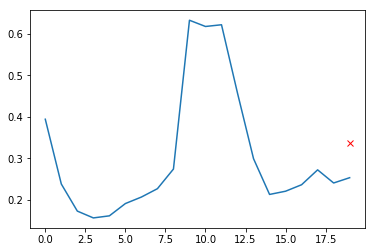

In [14]:
tax = np.arange(20)
plt.plot(tax, X_train[0, :, 0])
plt.plot(tax[-1], y_train[0, :, 0], 'rx')

# Model with LearningRateScheduler

In [15]:
mod = keras.Sequential()
mod.add(layers.SimpleRNN(36,
        input_shape = (X_train.shape[1], X_train.shape[2]),                        
        return_sequences=True))
mod.add(layers.SimpleRNN(36))
mod.add(layers.Dense(1))
mod.compile(optimizer=keras.optimizers.Adam(lr = 1e-5),
            loss=keras.losses.Huber(),
            metrics=['mae'])

In [16]:
# Source: https://gist.github.com/jeremyjordan/86398d7c05c02396c24661baa4c88165
from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=1.0, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75)

In [17]:
epoch = 200
bs = 20

In [18]:
history = mod.fit(X_train, 
          y_train, 
          epochs=epoch, 
          batch_size=bs, 
          validation_split=0.2,
          verbose=1,
          callbacks=[lr_sched])

Train on 348 samples, validate on 87 samples
Epoch 1/200
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
348/348 [==============================] - 2s 5ms/sample - loss: 0.5406 - mae: 1.0119 - val_loss: 0.3406 - val_mae: 0.8094
Epoch 2/200
348/348 [==============================] - 0s 704us/sample - loss: 0.1052 - mae: 0.3906 - val_loss: 0.0444 - val_mae: 0.2651
Epoch 3/200
348/348 [==============================] - 0s 682us/sample - loss: 0.0276 - mae: 0.1906 - val_loss: 0.0138 - val_mae: 0.1379
Epoch 4/200
348/348 [==============================] - 0s 689us/sample - loss: 0.0232 - mae: 0.1740 - val_loss: 0.0150 - val_mae: 0.1460
Epoch 5/200
348/348 [==============================] - 0s 670us/sample - loss: 0.0196 - mae: 0.1623 - val_loss: 0.0167 - val_mae: 0.1574
Epoch 6/200
348/348 [==============================] - 0s 698us/sample - loss: 0.0175 - mae: 0.1543 - val_loss: 0.0155 - val_mae: 0.1520
Epoch 7/200
348/348 [====================

In [19]:
mod.evaluate(X_test, y_test)

108/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.0017767373011102555, 0.047481555]

In [20]:
len(history.history["lr"]), history.history["lr"][-1]

(200, 4.2282826e-07)

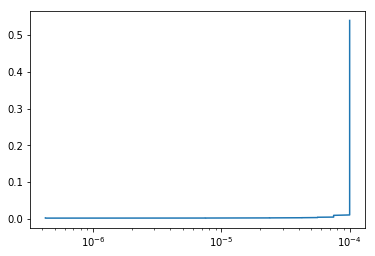

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-5, 1, 0, 10])

In [22]:
def plot_series(time, series, format="-", start=0, end=None, label="Data"):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

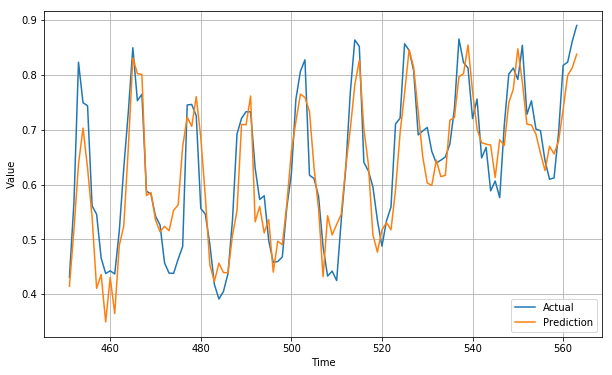

In [23]:
forecast=[]
for time in range(len(ser_scl) - look_back):
  forecast.append(mod.predict(ser_scl[time:time + look_back][np.newaxis]))

forecast = forecast[split_time - look_back:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))


plot_series(time_valid, ser_scl[split_time:], label="Actual")
plot_series(time_valid, results, label="Prediction")
plt.legend()

# Hyperparameter Optimization using keras-tuner

Tune:
 - Number of hidden units in SimpleRNN.
 - Learning rate: 1e-6, 1e-5, 1e-4.

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(123)
np.random.seed(123)

In [25]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.SimpleRNN(
        input_shape = (X_train.shape[1], X_train.shape[2]),                        
        units=hp.Int('units', min_value=20, max_value=100, step=20),
        return_sequences=True))
    model.add(layers.SimpleRNN(40))
    model.add(layers.Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-4, 1e-5, 1e-6])),
        loss=keras.losses.Huber(),
        metrics=['mae'])
    return model

In [26]:
tuner = RandomSearch(
    build_model,
    objective='mae',
    max_trials=TRIALS,
    executions_per_trial=2,
    directory='test_dir')

tuner.search_space_summary()

In [27]:
tuner.search(X_train, 
             y_train, 
             epochs=EPOCHS,
             validation_data=(X_test, y_test))

tuner.results_summary()

Name,Best model,Current model
mae,0.3264,0.3264
loss,0.0713,0.0713
val_loss,0.0667,0.0667
val_mae,0.3229,0.3229


Name,Best model,Current model
mae,0.3264,0.3413
loss,0.0713,0.105
val_loss,0.0618,0.0618
val_mae,0.2716,0.2716


Name,Best model,Current model
mae,0.3264,0.4498
loss,0.0713,0.1278
val_loss,0.0618,0.1436
val_mae,0.2716,0.5067


In [28]:
model = tuner.get_best_models(num_models=1)

history = model[0].fit(
            x=X_train,
            y=y_train, 
            epochs=200,
            batch_size=bs, 
            validation_split=0.2,
            verbose=1)

Train on 348 samples, validate on 87 samples
Epoch 1/200
348/348 [==============================] - 2s 5ms/sample - loss: 0.0586 - mae: 0.2915 - val_loss: 0.0735 - val_mae: 0.3344
Epoch 2/200
348/348 [==============================] - 0s 695us/sample - loss: 0.0576 - mae: 0.2886 - val_loss: 0.0717 - val_mae: 0.3298
Epoch 3/200
348/348 [==============================] - 0s 688us/sample - loss: 0.0565 - mae: 0.2859 - val_loss: 0.0700 - val_mae: 0.3255
Epoch 4/200
348/348 [==============================] - 0s 681us/sample - loss: 0.0555 - mae: 0.2832 - val_loss: 0.0683 - val_mae: 0.3212
Epoch 5/200
348/348 [==============================] - 0s 669us/sample - loss: 0.0546 - mae: 0.2807 - val_loss: 0.0669 - val_mae: 0.3176
Epoch 6/200
348/348 [==============================] - 0s 725us/sample - loss: 0.0537 - mae: 0.2780 - val_loss: 0.0654 - val_mae: 0.3137
Epoch 7/200
348/348 [==============================] - 0s 673us/sample - loss: 0.0528 - mae: 0.2755 - val_loss: 0.0638 - val_mae: 0.309

In [34]:
model[0].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 20, 60)            3720      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                4040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 7,801
Trainable params: 7,801
Non-trainable params: 0
_________________________________________________________________


<Figure size 432x288 with 0 Axes>

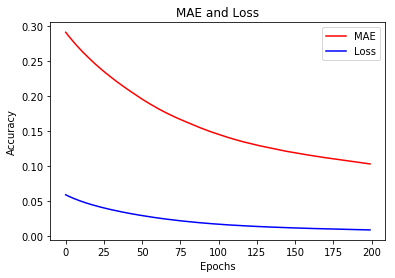

<Figure size 432x288 with 0 Axes>

In [29]:
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [30]:
mae[-1]

0.102826074

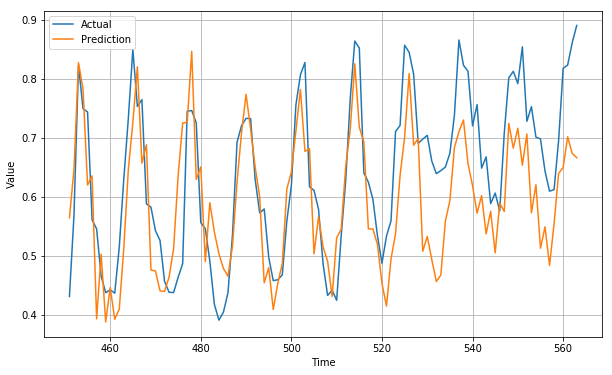

In [31]:
forecast=[]
for time in range(len(ser_scl) - look_back):
  forecast.append(model[0].predict(ser_scl[time:time + look_back][np.newaxis]))

forecast = forecast[split_time - look_back:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))


plot_series(time_valid, ser_scl[split_time:], label='Actual')
plot_series(time_valid, results, label='Prediction')
plt.legend()